# POTUS Election 2016 (3)

python = 3.7 

Analyse Debunking Communities 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import networkx as nx
import re
from joblib import dump, load
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 输出DataFrame时显示所有的列
pd.set_option('display.max_columns', None)
# 输出DataFrame时每行显示完整的内容
pd.set_option('display.max_colwidth', None)

## 分析辟谣社区的两个集中点

In [2]:
# 取出辟谣社区
communities_topn = load("pkl/communities_topn[topic=POTUS2016].pkl")
db_com = pd.DataFrame(communities_topn[2].copy())

### Toxicity-Positive

#### 绘制密度等高线图，并标出等高线的等级

In [3]:
from scipy.stats import gaussian_kde

def draw_toxicity_sentiment_contour(
        sentiment: str, 
        community: pd.DataFrame, 
        xlim,
        ylim,
        figsize=(10, 15), 
        level_num=10
    ):
    
    df = community.dropna(subset=[sentiment + '_score', 'toxicity_score']).reset_index(drop=True, inplace=False)
    x = df[sentiment + '_score']
    y = df['toxicity_score']

    # 使用 scipy 计算核密度估计
    xy = np.vstack([x,y])
    kde = gaussian_kde(xy)

    # 创建一个网格
    xmin, ymin = xy.min(axis=1)
    xmax, ymax = xy.max(axis=1)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    # 在网格上计算密度值
    Z = np.reshape(kde(positions).T, X.shape)
    levels = np.linspace(np.min(Z), np.max(Z), level_num)

    # 使用 matplotlib 绘制等高线图
    plt.figure(figsize=figsize)
    contour_set = plt.contour(X, Y, Z, levels=levels)
    plt.clabel(contour_set, inline=False, fontsize=8) # 在等高线上标注级别信息
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

    # 返回等高线信息
    return contour_set

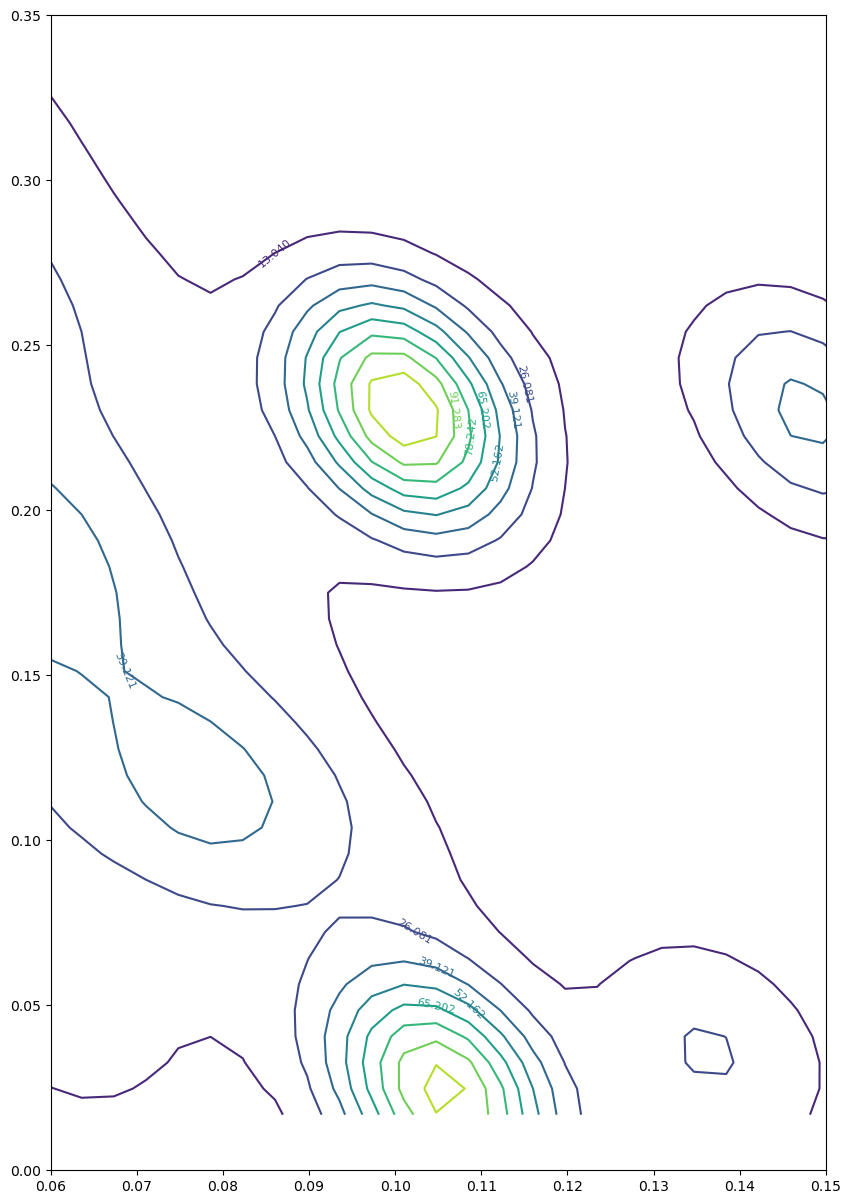

In [4]:
contour_set = draw_toxicity_sentiment_contour('positive', db_com, xlim=(0.06, 0.15), ylim=(0, 0.35))

In [5]:
# 等高线级别信息
print(contour_set.levels)

[3.66537033e-74 1.30403992e+01 2.60807984e+01 3.91211976e+01
 5.21615968e+01 6.52019960e+01 7.82423953e+01 9.12827945e+01
 1.04323194e+02 1.17363593e+02]


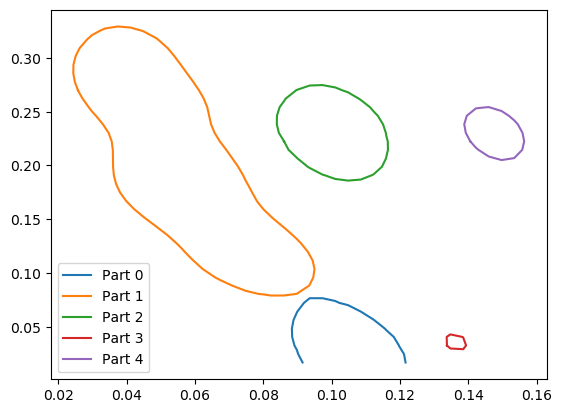

In [6]:
# 找到第2等级的等高线，把子等高线用颜色和序号区分
order = 2
segments = contour_set.allsegs[order]
for j, segment in enumerate(segments):
    plt.plot(segment[:, 0], segment[:, 1], label=f'Part {j}')

plt.legend()
plt.show()

##### 上方聚集区

In [7]:
import matplotlib.path as mpath

# 选择一个等高线的连续部分
part = 2
segment = segments[part]  # 选择第2个连续部分

# 创建一个Path对象，并检查每个点是否在等高线内
path = mpath.Path(segment)
df = db_com.dropna(subset=['positive_score', 'toxicity_score']).reset_index(drop=True, inplace=False)
df['upper_dense_area'] = path.contains_points(df[['positive_score', 'toxicity_score']].values)

# 落在等高线内的点
upper_points = df[df['upper_dense_area']]
upper_points.shape

(799, 13)

(-0.05, 0.7)

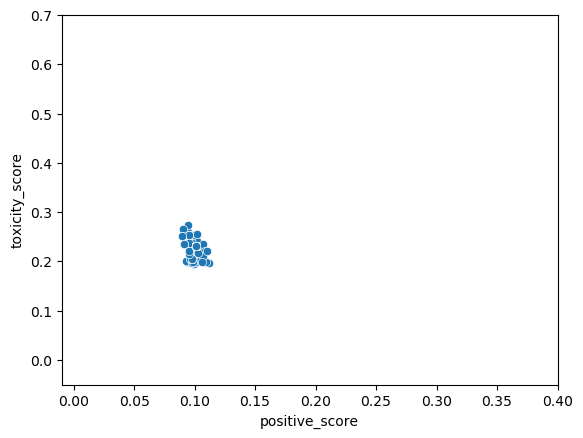

In [8]:
sns.scatterplot(x='positive_score', y='toxicity_score', data=upper_points)
plt.xlim(-0.01, 0.4)
plt.ylim(-0.05, 0.7)

In [9]:
upper_points.value_counts(['toxicity_score','positive_score'])

toxicity_score  positive_score
0.230907        0.101015          751
0.204383        0.097745            6
0.217762        0.102463            4
0.254052        0.095734            3
0.250844        0.089622            2
0.232350        0.095783            1
0.234514        0.107143            1
0.235235        0.090909            1
                0.090993            1
0.236678        0.095184            1
0.237399        0.097940            1
0.195044        0.099123            1
0.230907        0.094444            1
0.238121        0.102598            1
0.241222        0.102062            1
0.254052        0.098295            1
0.254629        0.102160            1
0.259157        0.094756            1
0.264817        0.090536            1
0.237399        0.100251            1
0.223114        0.104144            1
0.195994        0.098006            1
0.200097        0.104132            1
0.195994        0.111803            1
0.197894        0.106449            1
0.198934        0.0

##### 下方聚集区

In [10]:
import matplotlib.path as mpath

# 选择一个等高线的连续部分
part = 0
segment = segments[part]

# 创建一个Path对象，并检查每个点是否在等高线内
path = mpath.Path(segment)
df = db_com.dropna(subset=['positive_score', 'toxicity_score']).reset_index(drop=True, inplace=False)
df['lower_dense_area'] = path.contains_points(df[['positive_score', 'toxicity_score']].values)

# 落在等高线内的点
lower_points = df[df['lower_dense_area']]
lower_points.shape

(773, 13)

(-0.05, 0.7)

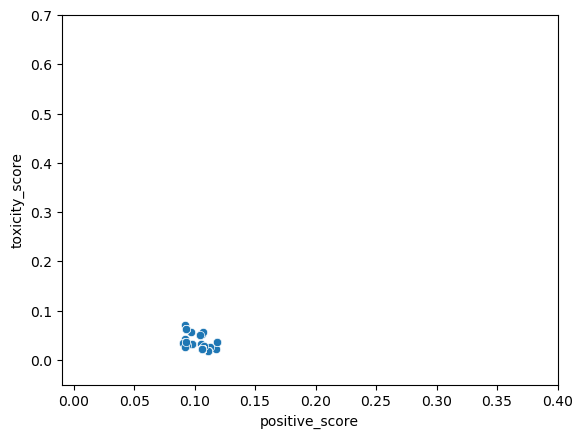

In [11]:
sns.scatterplot(x='positive_score', y='toxicity_score', data=lower_points)
plt.xlim(-0.01, 0.4)
plt.ylim(-0.05, 0.7)

In [13]:
lower_points.value_counts(['toxicity_score','positive_score'])

toxicity_score  positive_score
0.022964        0.105703          662
0.017216        0.111111           40
0.050821        0.104257           29
0.032392        0.098058           18
0.062632        0.092715            5
0.037341        0.118585            2
0.036634        0.092648            2
0.035220        0.090167            2
0.031096        0.093556            1
0.033099        0.105409            1
0.022375        0.117760            1
0.028739        0.107833            1
0.036870        0.091670            1
0.026028        0.112906            1
0.043399        0.092450            1
0.025321        0.092253            1
0.053295        0.106199            1
0.056264        0.096976            1
0.057501        0.106600            1
0.024496        0.105703            1
0.070546        0.091766            1
dtype: int64

## Debunking转推图

### 绘制转推图

In [3]:
# 取出debunking社区
communities_topn = load("pkl/communities_topn[topic=POTUS2016].pkl")
db_com = communities_topn[2].copy()
# 取出辟谣社区中的用户
user_db = set(db_com['Id'])
db_com.iloc[0:3, :]

,index,Id,Label,modularity_class,indegree,outdegree,degree,Color,toxicity_score,positive_score,negative_score,affect_score
0,1,PolitiFact,PolitiFact,1,14104,0,14104,#00c4ff,NaN,NaN,NaN,NaN
1,30,politifactlive,politifactlive,1,2731,0,2731,#00c4ff,NaN,NaN,NaN,NaN
2,18954,irin,irin,1,282,0,282,#00c4ff,NaN,NaN,NaN,NaN


In [22]:
tweets_contain_3media = pd.read_csv("data/3media_tweets_of_potus_election2016[time=16.10.10-16.12.19][lang=en].csv")
retweets_3media = tweets_contain_3media[tweets_contain_3media['referenced_tweets.retweeted.id'].notnull()]
df_urls = pd.read_csv("data/labeled_urls_of_potus_election_2016[time=16.10.10-16.12.19][lang=en].csv")
# 给每条转推标上转发的媒体域名
df_urls.index = df_urls['url']
retweets_3media['domain'] = ''
n = 0
for i in retweets_3media.index:
    mtch = list(re.findall('"(.+?)"', str(retweets_3media['entities.urls'][i])))
    retweets_3media['domain'][i] = [df_urls['domain'][url] for url in mtch]
    n += 1
    if n % 10000 == 0:
        print(int(n / 10000), end=' ')
# 保存标好域名的转推
retweets_3media.to_csv("data/3media_retweets[topic=POTUS2016][time=16.10.10-16.12.19][lang=en].csv", index=False)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 

In [29]:
# 根据辟谣社区的用户取出他们发的转推
index1 = retweets_3media['author.username'].isin(user_db)
index2 = retweets_3media['retweeted_username'].isin(user_db)
indexes = index1 | index2
db_retweets_3media = retweets_3media[indexes]

In [31]:
# 边列表
edge_list = pd.concat([db_retweets_3media['author.username'],db_retweets_3media['retweeted_username'],\
                       db_retweets_3media['domain']], axis=1)
edge_list.columns = ['source','target','label']
# 转换成图文件
D = nx.from_pandas_edgelist(edge_list, edge_attr='label', create_using=nx.DiGraph)    # 利用边的信息来构建有向图
nx.write_gexf(D, "pkl/debunking_RTnetworks[topic=POTUS2016][time=16.10.10-16.12.19][lang=en].gexf")  # 保存有向图数据

### 分析辟谣社区子社区

In [73]:
vexes = pd.read_csv("data/(vertices)debunking_RTnetworks[modularity=2][topic=POTUS2016][time=16.10.10-16.12.19][lang=en].csv")
vexes.sort_values(['indegree'], ascending=False, inplace=True)
top3_list = [(0, 0.7552), (1, 0.1551), (6, 0.0842)]

#### 社区0

In [80]:
vexes[vexes['modularity_class'] == top3_list[0][0]].head(10)

,Id,Label,modularity_class,indegree,outdegree,degree,Color
1,PolitiFact,PolitiFact,0,14104,0,14104,#df89ff
11376,simbel_myne,simbel_myne,0,0,1,1,#df89ff
11479,OlearyPatty,OlearyPatty,0,0,1,1,#df89ff
11477,_featherweather,_featherweather,0,0,1,1,#df89ff
11378,almadenm49,almadenm49,0,0,1,1,#df89ff
11505,sksgrigsby,sksgrigsby,0,0,1,1,#df89ff
11352,JaimeSoSweet,JaimeSoSweet,0,0,1,1,#df89ff
11373,ktharris08,ktharris08,0,0,1,1,#df89ff
11379,mrobin032009,mrobin032009,0,0,1,1,#df89ff
11501,xFloralGreen,xFloralGreen,0,0,1,1,#df89ff


##### T-P

In [ ]:
len(set(upper_points['Id']).intersection(set(vexes[vexes['modularity_class'] == top3_list[0][0]]['Id'])))

In [ ]:
len(set(lower_points['Id']).intersection(set(vexes[vexes['modularity_class'] == top3_list[0][0]]['Id'])))